<a href="https://colab.research.google.com/github/Szczempus/computer-vision/blob/main/PlantCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils

In [3]:
pip install plantcv

     |████████████████████████████████| 215kB 11.4MB/s 
     |████████████████████████████████| 48.6MB 96kB/s 
     |████████████████████████████████| 675kB 32.1MB/s 
ERROR: distributed 2021.3.0 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: dask-jobqueue 0.7.2 has requirement dask>=2.19, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [4]:
import os
import argparse
from plantcv import plantcv as pcv
pcv.params.debug = "plot"

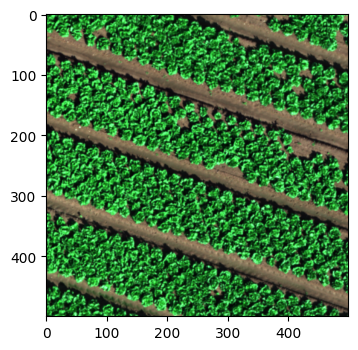

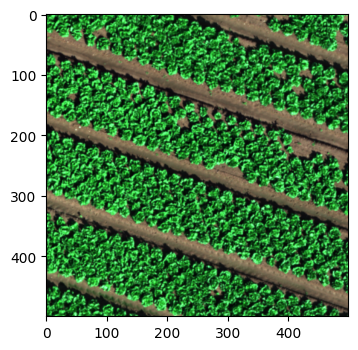

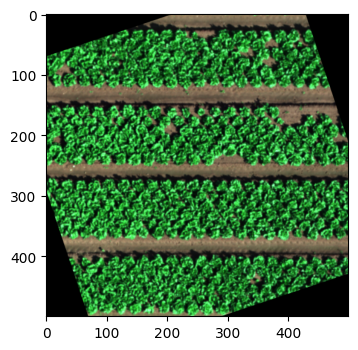

In [5]:
img, path, filename = pcv.readimage(filename='salata5-2-16.png', mode = 'rgb')
pcv.plot_image(img)
img = imutils.rotate(image=img, angle = 18.5)
pcv.plot_image(img)

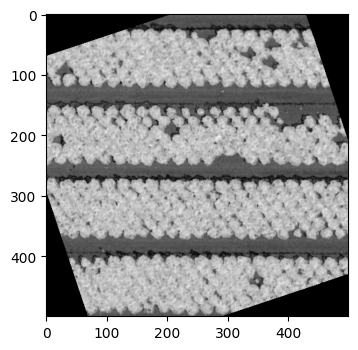

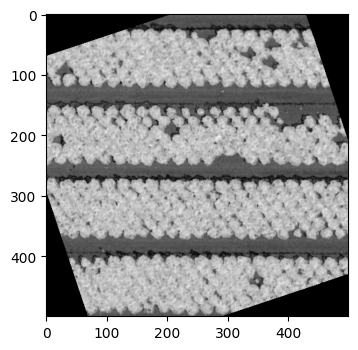

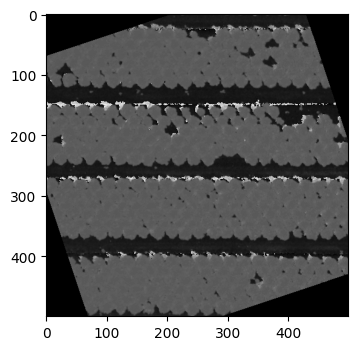

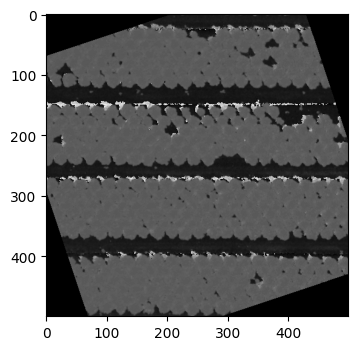

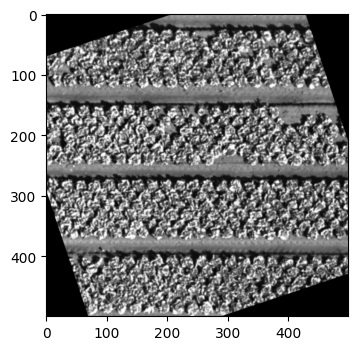

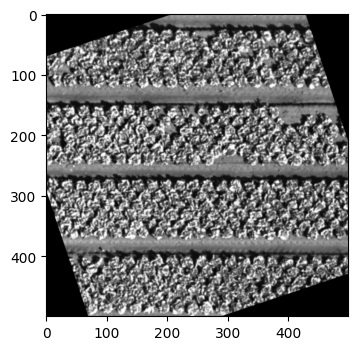

In [6]:
# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_image - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
HSV_Simage = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
pcv.plot_image(HSV_Simage)
HSV_Himage = pcv.rgb2gray_hsv(rgb_img=img, channel='h')
pcv.plot_image(HSV_Himage)
HSV_Vimage = pcv.rgb2gray_hsv(rgb_img=img, channel='V')
pcv.plot_image(HSV_Vimage)

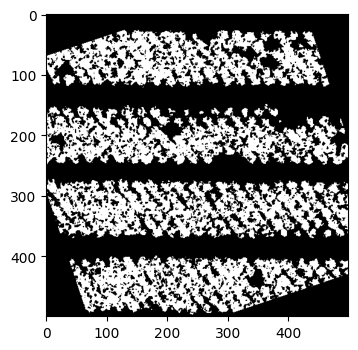

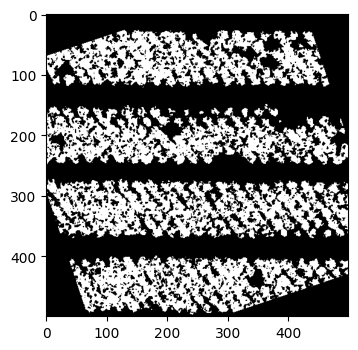

In [7]:
# Threshold the saturation image

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than the 
#                 background then standard threshold is done. If the object is 
#                 darker than the background then inverse thresholding is done. 
HSV_Simage_thersh = pcv.threshold.binary(gray_img=HSV_Simage, threshold=180, max_value=255, object_type='light')
pcv.plot_image(HSV_Simage_thersh)

First branch of workflow (RGB image to LAB)


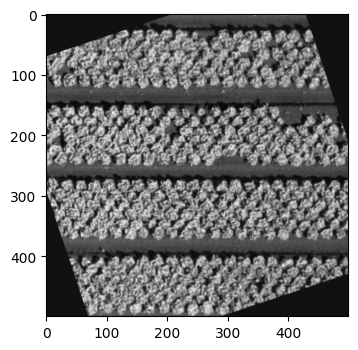

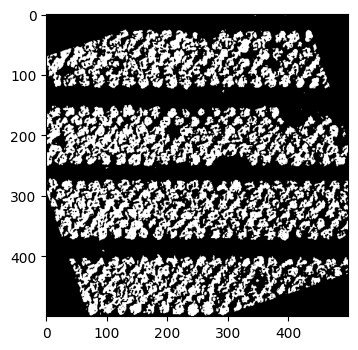

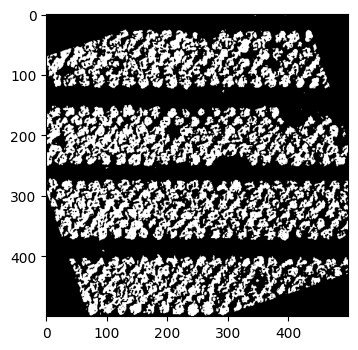

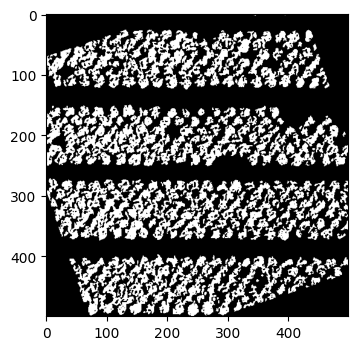

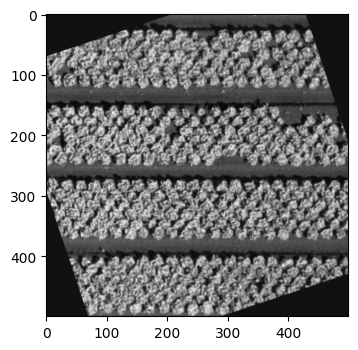

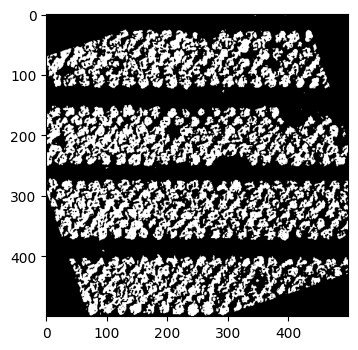

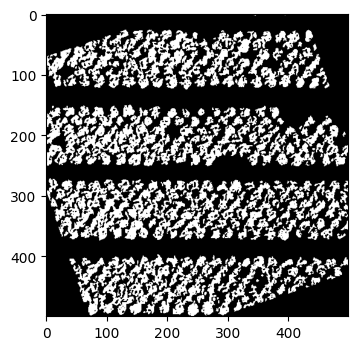

In [8]:
# Convert RGB to LAB and extract the Blue channel

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
Blue_image = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=Blue_image, threshold=160, max_value=255, 
                                object_type='light')
b_cnt = pcv.threshold.binary(gray_img=Blue_image, threshold=160, max_value=255, 
                                 object_type='light')
# Fill small objects (optional)
b_fill = pcv.fill(b_thresh, 10)
pcv.plot_image(Blue_image)
pcv.plot_image(b_thresh)
pcv.plot_image(b_fill)

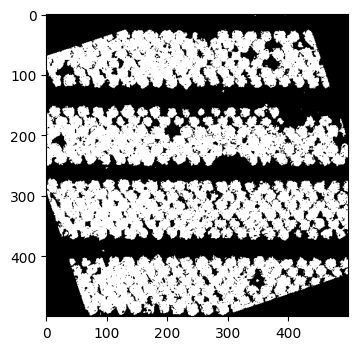

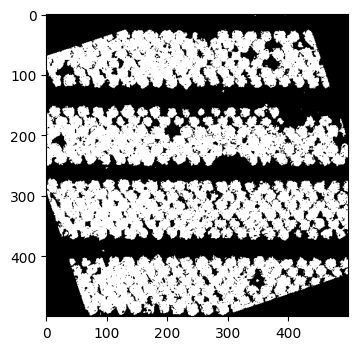

In [9]:
    # Join the thresholded saturation and blue-yellow images

    # Inputs: 
    #   bin_img1 - Binary image data to be compared to bin_img2
    #   bin_img2 - Binary image data to be compared to bin_img1
    bs = pcv.logical_or(bin_img1=HSV_Simage_thersh, bin_img2=b_cnt)
    pcv.plot_image(bs)

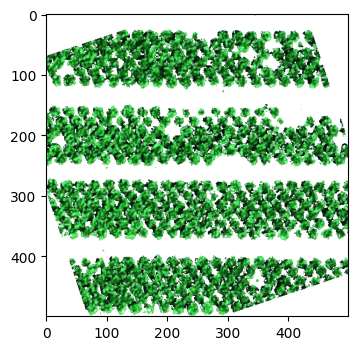

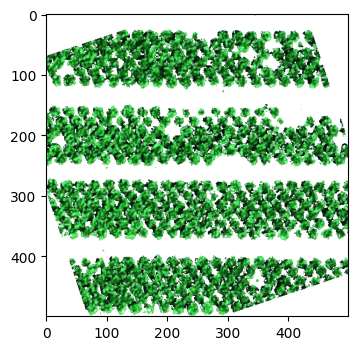

In [10]:
# Apply Mask (for VIS images, mask_color=white)

# Inputs:
#   rgb_img - RGB image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(img = img, mask=bs, mask_color='white')
pcv.plot_image(masked)
pcv.print_image(masked, 'masked.png')

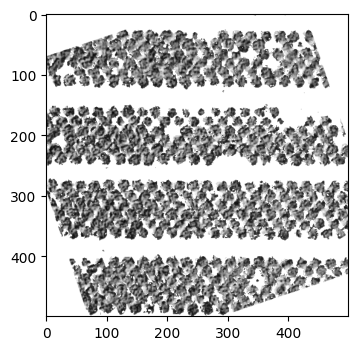

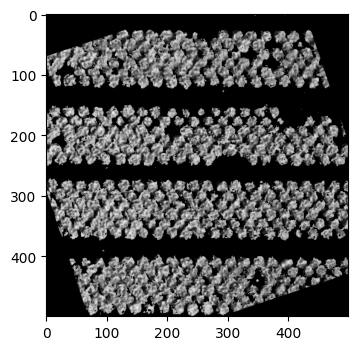

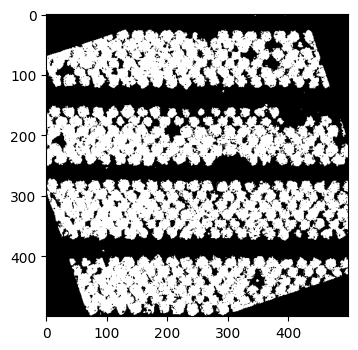

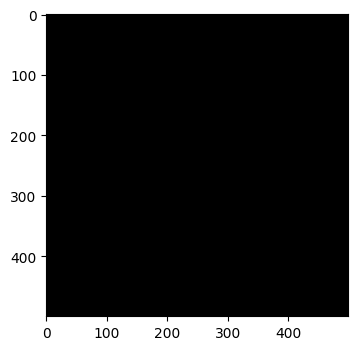

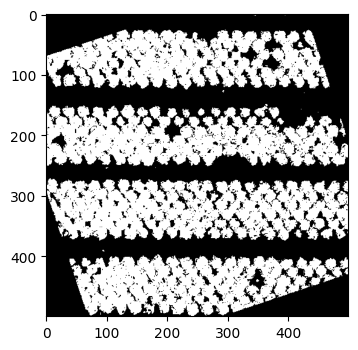

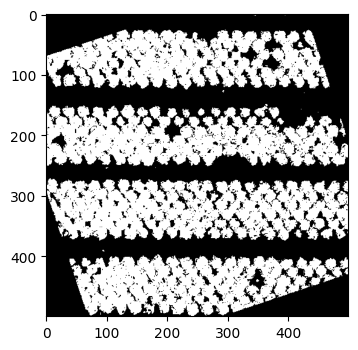

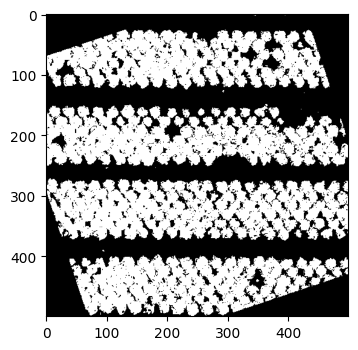

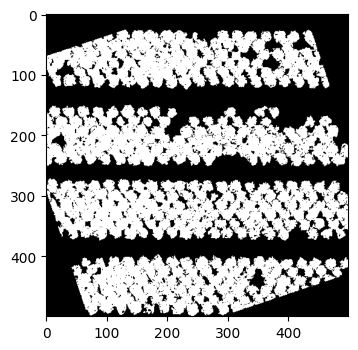

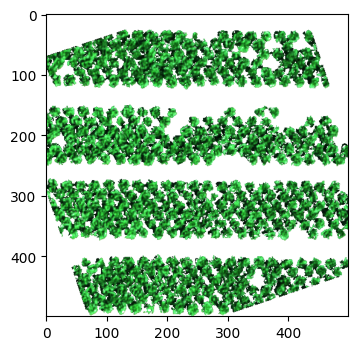

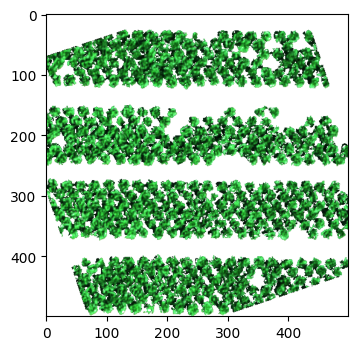

In [11]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')

# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                  max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                        max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, 
                                      max_value=255, object_type='light')

# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)

# Fill small objects
# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
ab_fill = pcv.fill(bin_img=ab, size=200)

# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')
pcv.plot_image(masked2)

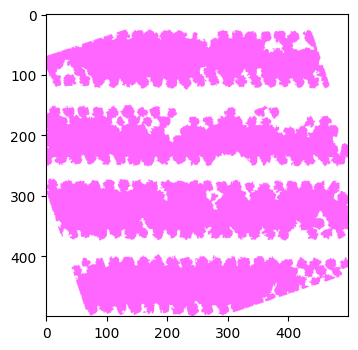

In [12]:
# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(masked2, ab_fill)

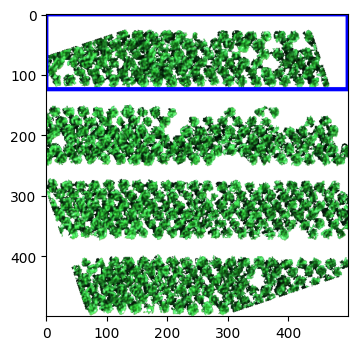

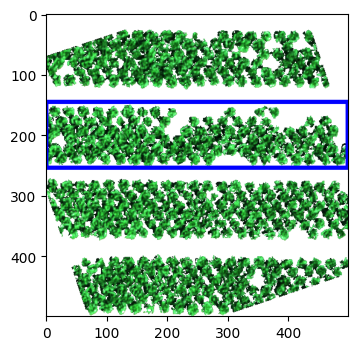

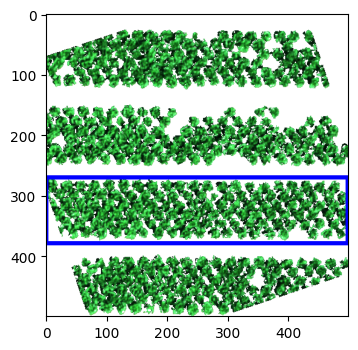

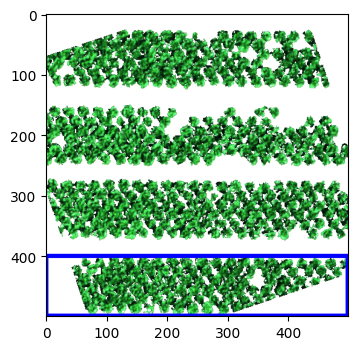

In [13]:
# Define ROI

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi1, roi_hierarchy1= pcv.roi.rectangle(img=masked2, x=0, y=0, h=125, w=500)
roi2, roi_hierarchy2= pcv.roi.rectangle(img=masked2, x=0, y=145, h=110, w=500)
roi3, roi_hierarchy3= pcv.roi.rectangle(img=masked2, x=0, y=270, h=110, w=500)
roi4, roi_hierarchy4= pcv.roi.rectangle(img=masked2, x=0, y=400, h=100, w=500)

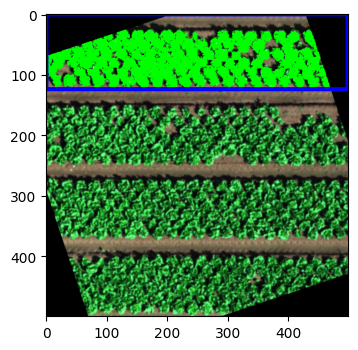

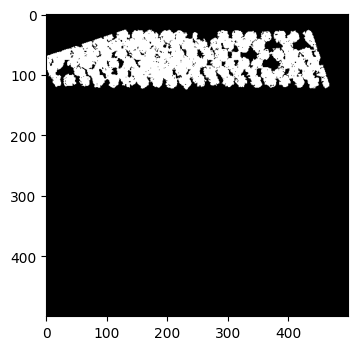

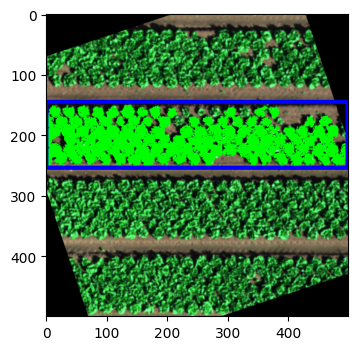

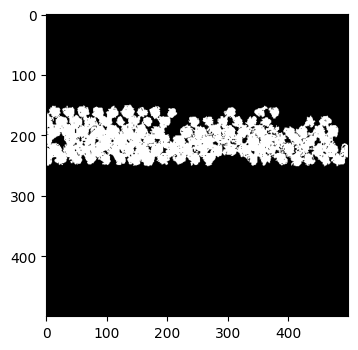

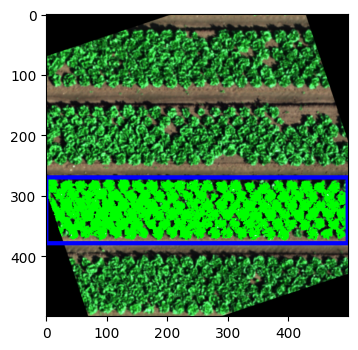

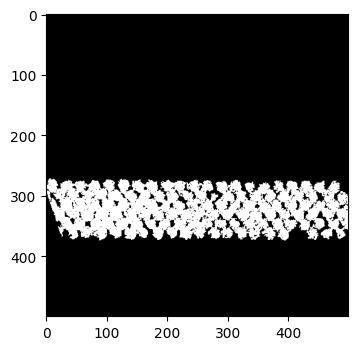

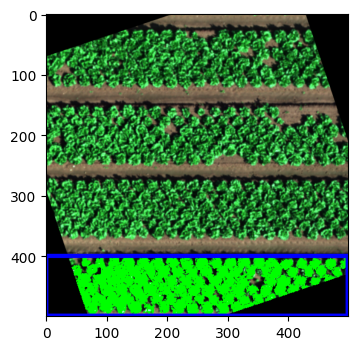

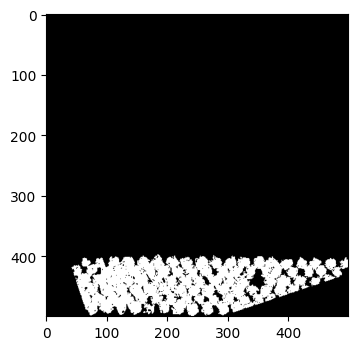

In [14]:
# Decide which objects to keep
# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside), 'cutto', or 
#    'largest' (keep only largest contour)
roi_objects_1, hierarchy3_1, kept_mask_1, obj_area_1 = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                                roi_hierarchy=roi_hierarchy1, 
                                                                object_contour=id_objects, 
                                                                obj_hierarchy=obj_hierarchy,
                                                                roi_type='partial')
roi_objects_2, hierarchy3_2, kept_mask_2, obj_area_2 = pcv.roi_objects(img=img, roi_contour=roi2, 
                                                                roi_hierarchy=roi_hierarchy2, 
                                                                object_contour=id_objects, 
                                                                obj_hierarchy=obj_hierarchy,
                                                                roi_type='partial')
roi_objects_3, hierarchy3_3, kept_mask_3, obj_area_3 = pcv.roi_objects(img=img, roi_contour=roi3, 
                                                                roi_hierarchy=roi_hierarchy3, 
                                                                object_contour=id_objects, 
                                                                obj_hierarchy=obj_hierarchy,
                                                                roi_type='partial')
roi_objects_4, hierarchy3_4, kept_mask_4, obj_area_4 = pcv.roi_objects(img=img, roi_contour=roi4, 
                                                                roi_hierarchy=roi_hierarchy4, 
                                                                object_contour=id_objects, 
                                                                obj_hierarchy=obj_hierarchy,
                                                                roi_type='partial')   

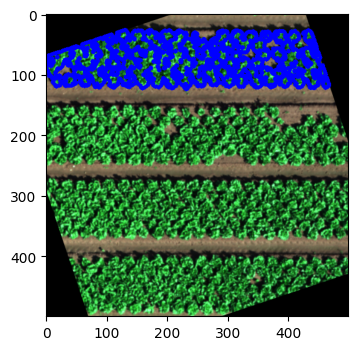

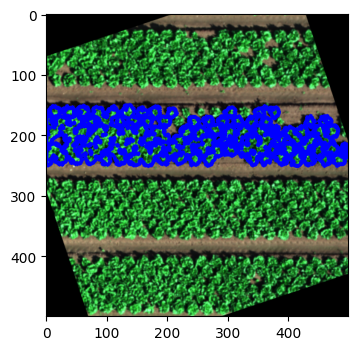

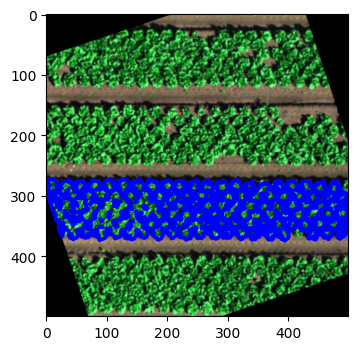

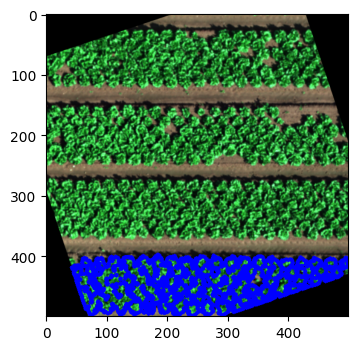

In [15]:
# Object combine kept objects
# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
obj_1, mask_1 = pcv.object_composition(img=img, contours=roi_objects_1, hierarchy=hierarchy3_1)
obj_2, mask_2 = pcv.object_composition(img=img, contours=roi_objects_2, hierarchy=hierarchy3_2)
obj_3, mask_3 = pcv.object_composition(img=img, contours=roi_objects_3, hierarchy=hierarchy3_3)
obj_4, mask_4 = pcv.object_composition(img=img, contours=roi_objects_4, hierarchy=hierarchy3_4)

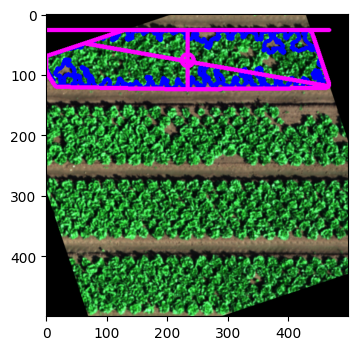

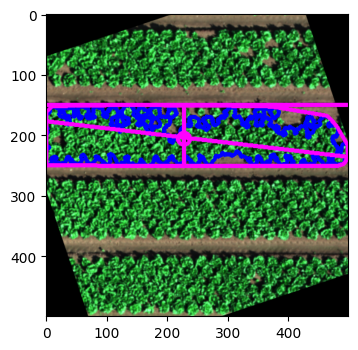

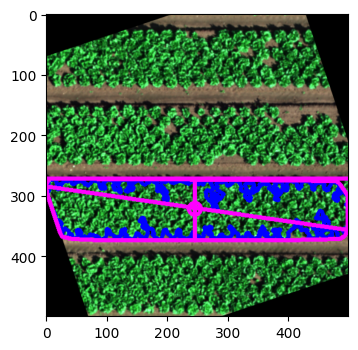

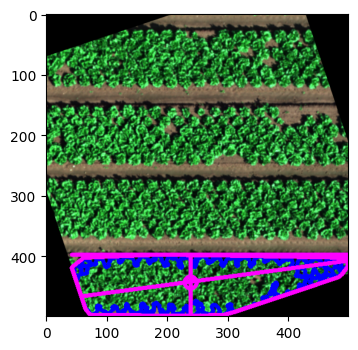

In [17]:
    # Find shape properties, output shape image (optional)

    # Inputs:
    #   img - RGB or grayscale image data 
    #   obj- Single or grouped contour object
    #   mask - Binary image mask to use as mask for moments analysis  
    #   label - Optional label parameter, modifies the variable name of observations recorded   
    shape_img = pcv.analyze_object(img=img, obj=obj_1, mask=mask_1, label="default")
    shape_img = pcv.analyze_object(img=img, obj=obj_2, mask=mask_2, label="default")
    shape_img = pcv.analyze_object(img=img, obj=obj_3, mask=mask_3, label="default")
    shape_img = pcv.analyze_object(img=img, obj=obj_4, mask=mask_4, label="default")